# HW 5: Forecasting Dynamics of Lorenz Equations
Shaunak Bhide

In [12]:
#necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

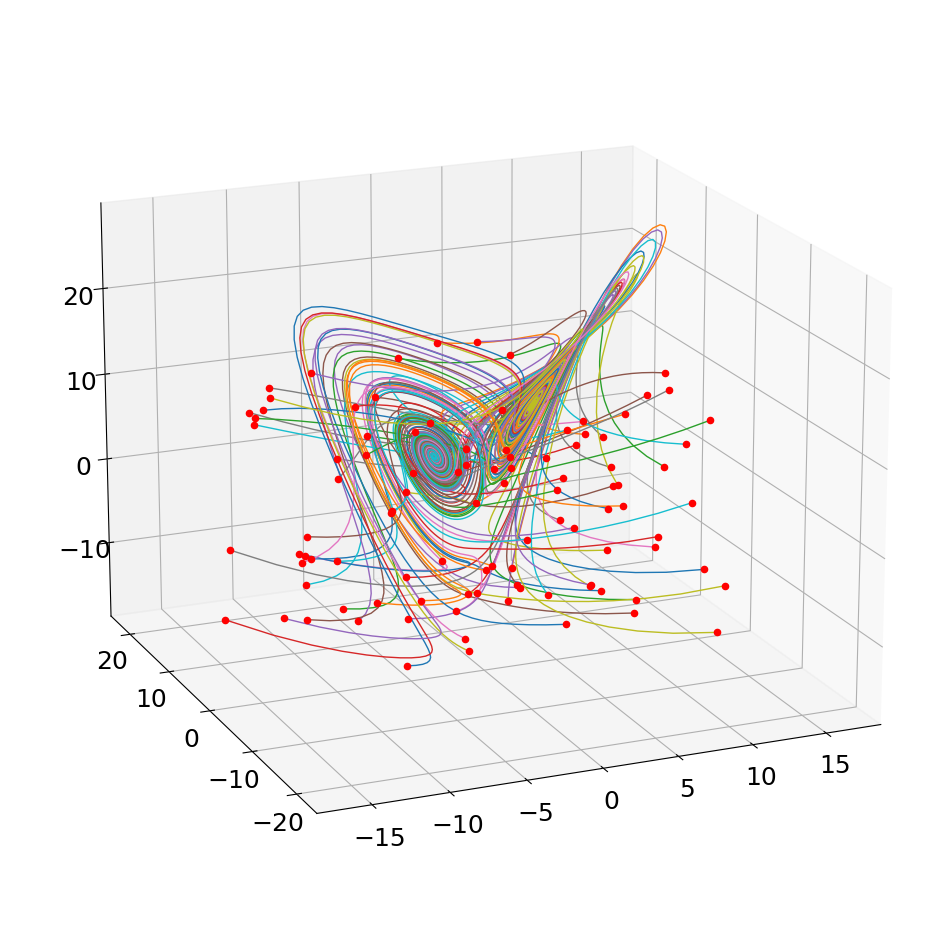

In [13]:
#Lorenz equation
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 10


nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])



for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
             
ax.view_init(18, -113)
plt.show()

In [14]:


# Define the model architecture
# 3 layer FFNN 
# layer sizes 3, 64, 3
# ReLU activation
class FFNNModel(nn.Module):
    def __init__(self):
        super(FFNNModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [15]:
def train_and_test_model(rho_train_values, rho_test_values):
    print("Generating training data...")
    # Generate training data
    nn_input = []
    nn_output = []
    for rho in rho_train_values:
        temp_input, temp_output = generate_lorenz_data(rho)
        nn_input.append(temp_input)
        nn_output.append(temp_output)
    nn_input = np.vstack(nn_input)
    nn_output = np.vstack(nn_output)
    print("Training data generated.")
    
    # Convert numpy arrays to PyTorch tensors
    nn_input = torch.from_numpy(nn_input).float()
    nn_output = torch.from_numpy(nn_output).float()

    # Create model instance
    model = FFNNModel()

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0007)

    print("Training model...")
    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, loss = {loss.item():.6f}")
    print("FFNN Model training complete.")
    
    print("Testing model...")
    # Test the model
    for rho in rho_test_values:
        test_input, test_output = generate_lorenz_data(rho)
        test_input = torch.from_numpy(test_input).float()
        test_output = torch.from_numpy(test_output).float()

        model.eval()
        with torch.no_grad():
            future_state_predictions = []
            current_state = test_input[0:1]
            for _ in range(len(test_input) - 1):
                next_state_prediction = model(current_state)
                future_state_predictions.append(next_state_prediction)
                current_state = next_state_prediction

            future_state_predictions = torch.vstack(future_state_predictions)
        mse_loss = criterion(future_state_predictions, test_output[:-1]).item()
        print(f"FFNN Test MSE loss for rho = {rho}: {mse_loss:.6f}")
    print("Model testing complete.")

def generate_lorenz_data(rho):
    print(f"Generating Lorenz data for rho = {rho}")
    dt = 0.01
    T = 8
    t = np.arange(0, T + dt, dt)
    beta = 8 / 3
    sigma = 10

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((100, 3))

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

    nn_input = np.zeros((100 * (len(t) - 1), 3))
    nn_output = np.zeros_like(nn_input)

    for j in range(100):
        nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
        nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]

    print(f"Lorenz data generated for rho = {rho}")
    return nn_input, nn_output

# Train and test the model for different rho values
rho_train_values = [10, 28, 40]
rho_test_values = [17, 35]
train_and_test_model(rho_train_values, rho_test_values)


Generating training data...
Generating Lorenz data for rho = 10
Lorenz data generated for rho = 10
Generating Lorenz data for rho = 28
Lorenz data generated for rho = 28
Generating Lorenz data for rho = 40
Lorenz data generated for rho = 40
Training data generated.
Training model...
Epoch 10, loss = 195.107681
Epoch 20, loss = 126.746712
Epoch 30, loss = 68.008759
Epoch 40, loss = 27.159933
Epoch 50, loss = 9.059574
Epoch 60, loss = 4.535765
Epoch 70, loss = 3.316052
Epoch 80, loss = 2.921666
Epoch 90, loss = 2.361166
Epoch 100, loss = 2.023882
FFNN Model training complete.
Testing model...
Generating Lorenz data for rho = 17
Lorenz data generated for rho = 17
FFNN Test MSE loss for rho = 17: 113.076546
Generating Lorenz data for rho = 35
Lorenz data generated for rho = 35
FFNN Test MSE loss for rho = 35: 428.518188
Model testing complete.


In [24]:
# LSTM test

def generate_data(rho_values):
    sigma = 10
    beta = 8/3
    dt = 0.02
    T = 4
    t = np.arange(0, T+dt, dt)

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho_current=None):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho_current - z) - y, x * y - beta * z]

    nn_input = []
    nn_output = []

    for rho in rho_values:
        x0 = -15 + 30 * np.random.random((50, 3))
        x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(sigma, beta, rho)) for x0_j in x0])

        for j in range(50):
            nn_input.extend(x_t[j,:-1,:])
            nn_output.extend(x_t[j,1:,:])

    return np.array(nn_input), np.array(nn_output)

print("Generating training data...")
train_rho_values = [10, 28, 40]
x_train, y_train = generate_data(train_rho_values)
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
print("Training data generation completed.\n")

print("Defining the LSTM model...")
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, 1, self.hidden_dim).requires_grad_()
        x = x.unsqueeze(0)  # Add an extra dimension for batching
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

print("Model defined.\n")

print("Initializing the model...")
model = LSTMModel(3, 50, 3, 1)
print("Model initialized.\n")

print("Defining loss criterion and optimizer...")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Loss criterion and optimizer defined.\n")

print("Training the model...")
for epoch in range(100):
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
    optimizer.zero_grad()
    outputs = model(x_train_torch)
    loss = criterion(outputs, y_train_torch)
    if epoch % 10 == 0:
        print("Current loss: ", loss.item())
    loss.backward()
    optimizer.step()
print("Training completed.\n")



Generating training data...
Training data generation completed.

Defining the LSTM model...
Model defined.

Initializing the model...
Model initialized.

Defining loss criterion and optimizer...
Loss criterion and optimizer defined.

Training the model...
Epoch:  0
Current loss:  310.4940490722656
Epoch:  10
Current loss:  242.22352600097656
Epoch:  20
Current loss:  200.39102172851562
Epoch:  30
Current loss:  167.7202911376953
Epoch:  40
Current loss:  144.16966247558594
Epoch:  50
Current loss:  130.95242309570312
Epoch:  60
Current loss:  124.51333618164062
Epoch:  70
Current loss:  122.00657653808594
Epoch:  80
Current loss:  121.3816146850586
Epoch:  90
Current loss:  121.3694076538086
Training completed.



In [25]:
test_rho_values = [17, 35]

for rho in test_rho_values:
    print(f"\nGenerating test data for rho = {rho}...")
    x_test, y_test = generate_data([rho])  # Generate test data for this rho
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)
    print(f"Test data generation for rho = {rho} completed.\n")

    print(f"Running prediction on test data for rho = {rho}...")
    y_pred = model(x_test_torch)
    print(f"Prediction for rho = {rho} completed.\n")

    print(f"Calculating MSE loss on test data for rho = {rho}...")
    mse_loss = criterion(y_pred, y_test_torch)
    print(f"Test MSE Loss for rho = {rho}: ", mse_loss.item())


Generating test data for rho = 17...
Test data generation for rho = 17 completed.

Running prediction on test data for rho = 17...
Prediction for rho = 17 completed.

Calculating MSE loss on test data for rho = 17...
Test MSE Loss for rho = 17:  63.170257568359375

Generating test data for rho = 35...
Test data generation for rho = 35 completed.

Running prediction on test data for rho = 35...
Prediction for rho = 35 completed.

Calculating MSE loss on test data for rho = 35...
Test MSE Loss for rho = 35:  128.3080291748047


In [18]:
# Echo State Network (ESN) test
print("Generating training data...")
train_rho_values = [10, 28, 40]
x_train, y_train = generate_data(train_rho_values)
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
print("Training data generation completed.\n")

print("Defining the ESN model...")
class ESN(nn.Module):
    def __init__(self, input_dim, reservoir_dim, output_dim):
        super(ESN, self).__init__()
        self.reservoir_dim = reservoir_dim
        self.input_weights = nn.Parameter(torch.randn(input_dim, reservoir_dim) / np.sqrt(input_dim), requires_grad=False)
        self.reservoir_weights = nn.Parameter(torch.randn(reservoir_dim, reservoir_dim), requires_grad=False)
        self.output_weights = nn.Parameter(torch.zeros(reservoir_dim, output_dim))

    def forward(self, x):
        reservoir_state = torch.tanh(x @ self.input_weights + self.reservoir_state @ self.reservoir_weights)
        self.reservoir_state = reservoir_state
        return reservoir_state @ self.output_weights

    def reset_state(self):
        self.reservoir_state = torch.zeros(1, self.reservoir_dim)

print("ESN Model defined.\n")

print("Initializing the model...")
model = ESN(3, 50, 3)
model.reset_state()
print("Model initialized.\n")

print("Defining loss criterion and optimizer...")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Loss criterion and optimizer defined.\n")

print("Training the model...")
for epoch in range(100):
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
    optimizer.zero_grad()
    model.reset_state()
    outputs = model(x_train_torch)
    loss = criterion(outputs, y_train_torch)
    if epoch % 10 == 0:
        print("Current loss: ", loss.item())
    loss.backward()
    optimizer.step()
print("Training completed.\n")



Generating training data...
Training data generation completed.

Defining the ESN model...
ESN Model defined.

Initializing the model...
Model initialized.

Defining loss criterion and optimizer...
Loss criterion and optimizer defined.

Training the model...
Epoch:  0
Current loss:  304.5351867675781
Epoch:  10
Current loss:  238.817626953125
Epoch:  20
Current loss:  186.73060607910156
Epoch:  30
Current loss:  147.827392578125
Epoch:  40
Current loss:  119.93755340576172
Epoch:  50
Current loss:  100.28182983398438
Epoch:  60
Current loss:  86.53630828857422
Epoch:  70
Current loss:  77.08189392089844
Epoch:  80
Current loss:  70.76200103759766
Epoch:  90
Current loss:  66.66841125488281
Training completed.



In [19]:
#Testing the ESN
test_rho_values = [17, 35]

for rho in test_rho_values:
    print(f"\nGenerating test data for rho = {rho}...")
    x_test, y_test = generate_data([rho])  # Generate test data for this rho
    x_test_torch = torch.tensor(x_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)
    print(f"Test data generation for rho = {rho} completed.\n")

    print(f"Resetting model state and running prediction on test data for rho = {rho}...")
    model.reset_state()
    y_pred = model(x_test_torch)
    print(f"Prediction for rho = {rho} completed.\n")

    print(f"Calculating MSE loss on test data for rho = {rho}...")
    mse_loss = criterion(y_pred, y_test_torch)
    print(f"ESN Test MSE Loss for rho = {rho}: ", mse_loss.item())



Generating test data for rho = 17...
Test data generation for rho = 17 completed.

Resetting model state and running prediction on test data for rho = 17...
Prediction for rho = 17 completed.

Calculating MSE loss on test data for rho = 17...
ESN Test MSE Loss for rho = 17:  24.252758026123047

Generating test data for rho = 35...
Test data generation for rho = 35 completed.

Resetting model state and running prediction on test data for rho = 35...
Prediction for rho = 35 completed.

Calculating MSE loss on test data for rho = 35...
ESN Test MSE Loss for rho = 35:  73.1640853881836


In [20]:
# Generating and training the RNN


print("Generating training data...")
train_rho_values = [10, 28, 40]
x_train, y_train = generate_data(train_rho_values)
x_train_torch = torch.tensor(x_train, dtype=torch.float32).unsqueeze(0)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
print("Training data generation completed.\n")

print("Defining the RNN model...")
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

print("Model defined.\n")

print("Initializing the model...")
model = SimpleRNN(3, 50, 3)
print("Model initialized.\n")

print("Defining loss criterion and optimizer...")
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Loss criterion and optimizer defined.\n")

print("Training the model...")
for epoch in range(100):
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
    optimizer.zero_grad()
    outputs = model(x_train_torch)
    loss = criterion(outputs, y_train_torch)
    if epoch % 10 == 0:
        print("Current loss: ", loss.item())
    loss.backward()
    optimizer.step()
print("Training completed.\n")


Generating training data...
Training data generation completed.

Defining the RNN model...
Model defined.

Initializing the model...
Model initialized.

Defining loss criterion and optimizer...
Loss criterion and optimizer defined.

Training the model...
Epoch:  0
Current loss:  310.31988525390625
Epoch:  10
Current loss:  224.5675506591797
Epoch:  20
Current loss:  179.94862365722656
Epoch:  30
Current loss:  149.27915954589844
Epoch:  40
Current loss:  132.65426635742188
Epoch:  50
Current loss:  125.69275665283203
Epoch:  60
Current loss:  123.65986633300781
Epoch:  70
Current loss:  123.37184143066406
Epoch:  80
Current loss:  123.4079360961914
Epoch:  90
Current loss:  123.41217803955078
Training completed.



In [21]:
# Testing the RNN
test_rho_values = [17, 35]

for rho in test_rho_values:
    print(f"\nGenerating test data for rho = {rho}...")
    x_test, y_test = generate_data([rho])  # Generate test data for this rho
    x_test_torch = torch.tensor(x_test, dtype=torch.float32).unsqueeze(0)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)
    print(f"Test data generation for rho = {rho} completed.\n")

    print(f"Running prediction on test data for rho = {rho}...")
    y_pred = model(x_test_torch)
    print(f"Prediction for rho = {rho} completed.\n")

    print(f"Calculating MSE loss on test data for rho = {rho}...")
    mse_loss = criterion(y_pred, y_test_torch)
    print(f"Test MSE Loss for rho = {rho}: ", mse_loss.item())


Generating test data for rho = 17...
Test data generation for rho = 17 completed.

Running prediction on test data for rho = 17...
Prediction for rho = 17 completed.

Calculating MSE loss on test data for rho = 17...
Test MSE Loss for rho = 17:  65.30432891845703

Generating test data for rho = 35...
Test data generation for rho = 35 completed.

Running prediction on test data for rho = 35...
Prediction for rho = 35 completed.

Calculating MSE loss on test data for rho = 35...
Test MSE Loss for rho = 35:  131.10218811035156
